# Basic solution
In this notebook, we walk through all basic steps for solving the house price regression problem. Especially the data exploration and preprocessing is kept very short though.

### Table of contents
* [Load data](#loaddata)
* [Define performance metric](#performance)
* [Deterministic baseline model](#baseline)
* [Preprocessing](#preprocessing)
    * [Handling missing values](#missing_values)
    * [Encoding categoricals](#encoding)
    * [Scaling](#scaling)
    * [Target transformation](#targettransformation)
* [Model selection](#modelselection)
* [Hyperparameter tuning](#hyperparameters)
* [Error plots](#errorplots)
* [Prediction](#prediction)
* [Conclusion](#conclusion)

In [3]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb  # faster than sklearn's gradient boosting
from typing import Dict

predictions_file = "../results/01_predictions.csv"
train_data_file = "../data/train.csv"
test_data_file = "../data/test.csv"
target_col = "SalePrice"

## Load data  <a class="anchor"  id="loaddata"></a>
Load the training and test set. Split the training set into feature matrix `X_train` and target vector `y_train` representing the `SalePrice`. The feature matrix of the test set is denoted by `X_test`. Also, the categorical and numerical features are determined which will be used in the [Preprocessing](#preprocessing).

In [4]:
train_df = pd.read_csv(train_data_file)
train_df.set_index("Id", inplace=True)
print(f"Shape: {train_df.shape}")
train_df.head()

Shape: (1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
y_train = train_df[target_col]
X_train = train_df.drop(columns=[target_col])

In [6]:
X_test = pd.read_csv(test_data_file)
X_test.set_index("Id", inplace=True)
print(f"Shape: {X_test.shape}")
X_test.head()

Shape: (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [7]:
cat_cols = X_train.select_dtypes(include=["object"]).columns
num_cols = X_train.select_dtypes(exclude=["object"]).columns

## Define performance metric <a class="anchor"  id="performance"></a>
As stated in the [challenge description](https://www.kaggle.com/competitions/home-data-for-ml-course/overview/evaluation), the RMSLE (root mean squared logarithmic error) is used for the performance metric. The definition is: 

$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=1}^{n_\text{samples}} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2}$

where $n_\text{samples}$ is the number of observations, and $y_i$ & $\hat{y}_i$ is the $i$-th real value or prediction of the target, respectively.

In order to use the RMSLE metric, one has to ensure that both, the real values and the predictions of the target are larger than $-1$. Otherwise the RMSLE is not defined. For the given target (sale price), the values should even be positive to be reasonable.
To ensure this for the predictions, the target can be log transformed before fitting since the inverse function (exponential function) is strictly positive. For the target transformation, see section [Target transformation](#targettransformation).

Since the training set is relatively small with 1460 observations, cross validation is used to get a more accurate estimate of the valdiation error. Using a 5-fold cross validation, there are 292 observations in each validation set which is acceptable.

In [8]:
CV = 5

neg_RMSLE_scorer = make_scorer(
    mean_squared_log_error, greater_is_better=False, squared=False
)
# note: greater_is_better=False only adds a minus sign


def measure_performance(estimator, X, y, scorer=neg_RMSLE_scorer, cv=CV):
    """Calculate negative RMSLE for train and validation set via cross validation."""
    cv_results = cross_validate(
        estimator=estimator,
        X=X,
        y=y,
        cv=cv,
        scoring=scorer,
        return_train_score=True,
    )
    train_error = cv_results["train_score"].mean()
    validation_error = cv_results["test_score"].mean()
    return train_error, validation_error

## Deterministic baseline model  <a class="anchor"  id="baseline"></a>
For a better comparison of the performance of the final model, the error of a simple deterministic model is calculated. A reasonable strategy is to predict the median or mean. To see what the error of a really poor model is, one can predict always zero.

In [9]:
dummy_median = DummyRegressor(strategy="median")  # reasonable strategy
dummy_median_train_error, dummy_median_validation_error = measure_performance(
    dummy_median, X_train, y_train
)
print(
    "RMSLE for a reasonable dummy regressor (median):\ntrain set:"
    f" {dummy_median_train_error}, validation set: {dummy_median_validation_error}"
)

dummy_constant0 = DummyRegressor(strategy="constant", constant=0.0)  # bad strategy
dummy_constant0_train_error, dummy_constant0_validation_error = measure_performance(
    dummy_constant0, X_train, y_train
)
print(
    "RMSLE for bad dummy regressor (constant 0):\ntrain set:"
    f" {dummy_constant0_train_error}, validation set:"
    f" {dummy_constant0_validation_error}"
)

RMSLE for a reasonable dummy regressor (median):
train set: -0.3998697229717904, validation set: -0.39968732140535296
RMSLE for bad dummy regressor (constant 0):
train set: -12.030685170503245, validation set: -12.030672042389956


## Preprocessing  <a class="anchor"  id="preprocessing"></a>

### Handling missing values <a class="anchor"  id="missing_values"></a>
As a simple approach, missing numerical data is imputed with the feature's mean (median would be also an option) and missing categorical data is imputed with the feature's most frequent value.

In [10]:
simple_imputer = ColumnTransformer(
    transformers=[
        (
            "num_imputer",
            SimpleImputer(strategy="mean", keep_empty_features=True),
            num_cols,
        ),
        (
            "cat_imputer",
            SimpleImputer(strategy="most_frequent", keep_empty_features=True),
            cat_cols,
        ),
    ],
    verbose_feature_names_out=False,
)
simple_imputer.set_output(transform="pandas")

# test it:
imputed_df = simple_imputer.fit_transform(X_train)
imputed_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
2,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
3,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
4,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,Detchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Abnorml
5,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal


### Encoding categoricals <a class="anchor"  id="encoding"></a>
As a simple approach, all categorical features are encoded ordinally. There may be features among them which are not ordinal and for which a one-hot encoding would be the better choice.

We could also one-hot encode all categoricals but that leads to a large amount of columns being prone to overfitting.

In [11]:
ordinal_encoder = ColumnTransformer(
    transformers=[
        (
            "ordinal_encoder",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            cat_cols,
        )
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
ordinal_encoder.set_output(transform="pandas")

# test it:
encoded_df = ordinal_encoder.fit_transform(imputed_df)
encoded_df.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,3.0,1.0,0.0,3.0,3.0,0.0,4.0,0.0,5.0,2.0,...,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0
2,3.0,1.0,0.0,3.0,3.0,0.0,2.0,0.0,24.0,1.0,...,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0
3,3.0,1.0,0.0,0.0,3.0,0.0,4.0,0.0,5.0,2.0,...,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0
4,3.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,6.0,2.0,...,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0
5,3.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,15.0,2.0,...,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0


### Scaling <a class="anchor"  id="scaling"></a>
For some machine learning algorithms that rely on scales, it is important to transform the features to a comparable scale before training. These algorithms include: 
- Algorithms based on gradient descent: linear regression, support vector machine, neural networks
- Distance-based algorithms: K-nearest neighbors, K-means clustering
- Algorithms with L1 or L2 regularization: Ridge regression, Lasso regression, Elastic Net regression
- Algorithms based on eigenvalue computation: PCA

On the other hand, all tree-based algorithms (decision tree, random forest, gradient boosted decision tree) are scale-invariant and therefore do not require any feature scaling.

Since we will compare different machine learning algorithms in chapter [Model selection](#modelselection), we will add a scaling in the preprocessing pipeline. There are several common options for scaling: `StandardScaler`, `MinMaxScaler` or `RobustScaler`. The latter one is less sensitive to outliers and skewed distributions.

Below, we check how many features in the training set contain outliers. For this, the IQR (interquartile range) method is used which is also suited for non-Gaussian distributions. An outlier $x$ is defined by the following condition:

$(x < \text{Q25} - \text{IQR} * \text{whisker\_width}) \lor (x > \text{Q75} + \text{IQR} * \text{whisker\_width}) $

where $\text{Q25}$, $\text{Q75}$ are the 25th or 75th percentile, respectively, and $\text{IQR} = \text{Q75} - \text{Q25}$. The $\text{whisker\_width}$ is a positive factor reflecting the severeness of the outliers. It is usually set to $1.5$.

We find 66 out of 79 features to show outliers (with $\text{whisker\_width}=1.5$) and therefore will use the `RobustScaler`.

In [12]:
def get_cols_with_outliers(df, whisker_width=1.5):
    """Determine all columns in df that contain outliers. Outliers are defined to be a
    factor of the IQR (interquartile range) below the 25th percentile or above the 75th
    percentile. The factor is denoted as whisker_width.
    Note: This method for outlier detection is also suited for non-Gaussian
    distributions."""
    q25 = df.quantile(0.25)
    q75 = df.quantile(0.75)
    iqr = q75 - q25
    small_outlier_filter = df < (q25 - whisker_width * iqr)
    large_outlier_filter = df > (q75 + whisker_width * iqr)
    outlier_filter = small_outlier_filter | large_outlier_filter
    col_has_outliers = outlier_filter.any()
    cols_with_outliers = col_has_outliers[col_has_outliers == True].index
    return cols_with_outliers

In [13]:
cols_with_outliers = get_cols_with_outliers(encoded_df)
print(
    f"There are {len(cols_with_outliers)} columns in the training set with"
    f" outliers:\n{cols_with_outliers}"
)

There are 66 columns in the training set with outliers:
Index(['MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities', 'LandSlope',
       'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2',
       'Heating', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass',
       'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch',

In [14]:
robust_scaler = RobustScaler()
robust_scaler.set_output(transform="pandas")

# test it:
scaled_df = robust_scaler.fit_transform(encoded_df)
scaled_df.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.7,0.0,...,0.281573,0.000000,0.529412,0.0,0.0,0.0,0.0,0.0,-1.333333,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.2,-1.0,...,-0.082816,1.773810,-0.367647,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.5
3,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-0.7,0.0,...,0.530021,0.000000,0.250000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0
4,0.0,0.0,0.0,-1.0,0.0,0.0,-2.0,0.0,-0.6,0.0,...,0.670807,0.000000,0.147059,272.0,0.0,0.0,0.0,0.0,-1.333333,-1.0
5,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.3,0.0,...,1.474120,1.142857,0.867647,0.0,0.0,0.0,0.0,0.0,2.000000,0.0


In [15]:
# get overview of statistics on the scaled columns:
scaled_df.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.028767,-0.004110,0.028082,-0.352511,-0.222603,0.000685,-0.490411,0.062329,0.025137,0.031507,...,-0.029068,0.560979,0.318533,21.954110,3.409589,15.060959,2.758904,43.489041,0.107306,-0.092123
std,0.632017,0.063996,0.165264,0.469719,0.707666,0.026171,0.811317,0.276232,0.601373,0.868515,...,0.885320,0.746064,0.974353,61.119149,29.317331,55.757415,40.177307,496.123024,0.901209,0.664048
min,-3.000000,-1.000000,0.000000,-1.000000,-3.000000,0.000000,-2.000000,0.000000,-1.200000,-2.000000,...,-1.987578,0.000000,-0.367647,0.000000,0.000000,0.000000,0.000000,0.000000,-1.666667,-1.000000
25%,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,-0.500000,0.000000,...,-0.602484,0.000000,-0.367647,0.000000,0.000000,0.000000,0.000000,0.000000,-0.333333,-0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,...,0.397516,1.000000,0.632353,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.500000
max,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.200000,6.000000,...,3.884058,5.101190,7.676471,552.000000,508.000000,480.000000,738.000000,15500.000000,2.000000,1.000000


### Target transformation <a class="anchor"  id="targettransformation"></a>
Log transform the target before fitting in order to ensure positive predictions. 

This also has the advantage that the target distribution approaches a normal distribution as shown below. Before transformation, the target distribution has a skewness of around $1.9$ and an excess kurtosis (measuring the "peakedness" of the distribution) of $6.5$. This is heavily skewed and also highly leptokurtic. A pure normal distribution has $0$ skewness and $0$ excess kurtosis. After transformation, the skewness is around $0.1$ and the excess kurtosis around $0.8$ which is an acceptable approximation to a normal distribution.

In [16]:
def check_distributions(distributions: Dict[str, pd.Series]):
    """Check similarity of given distributions compared to a normal distribution."""
    nr_dist = len(distributions)
    fig, axs = plt.subplots(nrows=nr_dist, ncols=2, figsize=(12, 5 * nr_dist))

    for count, name in enumerate(distributions):
        if nr_dist > 1:
            left_ax = axs[count, 0]
            right_ax = axs[count, 1]
        else:
            left_ax = axs[0]
            right_ax = axs[1]

        sns.histplot(distributions[name], kde=True, ax=left_ax)
        left_ax.set_title(name)
        left_text = f"nunique: {distributions[name].nunique()}"
        left_ax.text(x=0.7, y=0.85, s=left_text, transform=left_ax.transAxes)

        scipy.stats.probplot(distributions[name], plot=right_ax)
        right_text = (
            f"skew: {distributions[name].skew()}\nkurt={distributions[name].kurt()}"
        )
        right_ax.text(x=0.05, y=0.85, s=right_text, transform=right_ax.transAxes)

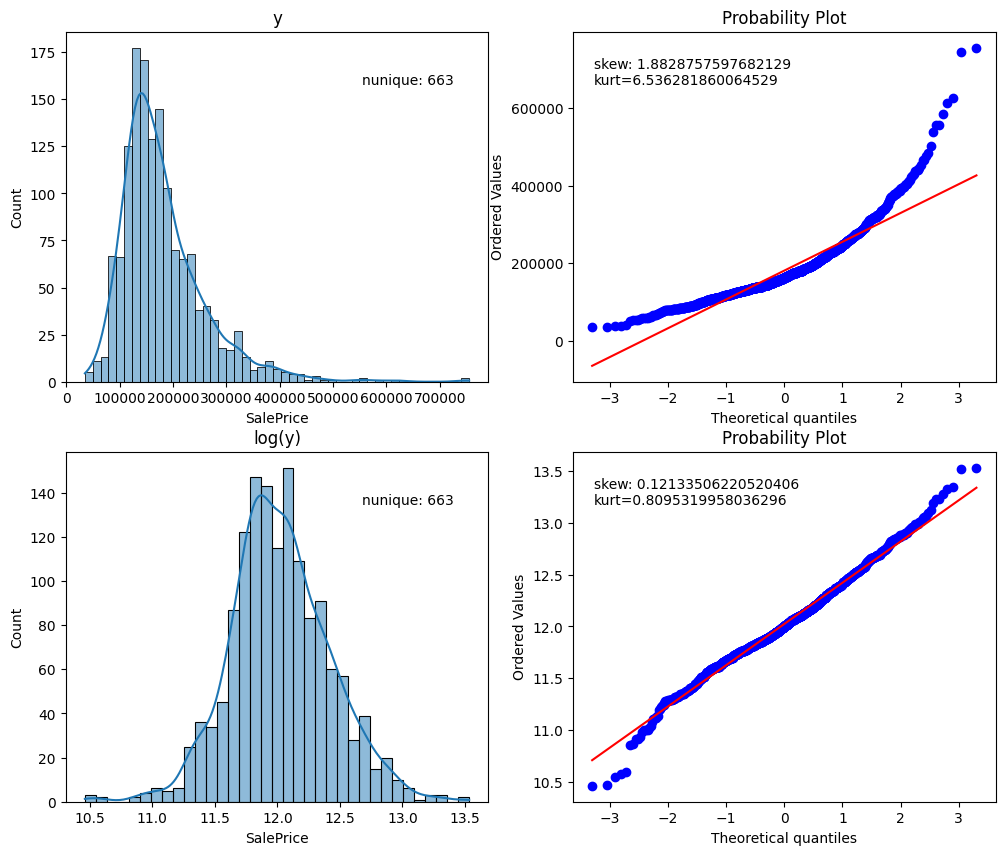

In [17]:
check_distributions({"y": y_train, "log(y)": np.log(y_train)})

In [18]:
def safe_log_inverse(log_y):
    # clip values in order to avoid overflows in exponential function
    log_y_clipped = np.clip(log_y, -sys.float_info.max, np.log(sys.float_info.max))
    y = np.exp(log_y_clipped)
    return y


def log_transform_target(estimator):
    return TransformedTargetRegressor(
        regressor=estimator, func=np.log, inverse_func=safe_log_inverse
    )

## Model selection  <a class="anchor"  id="modelselection"></a>

Compare different algorithms and select the one(s) that perform(s) best based on the validation error. For this selection, the default hyperparameters are used. Exceptions to this is the `objective` parameter of the `XGBRegressor` which should reflect the metric that we want to minimize (RMSLE), and the `max_iter` parameter in the `MLPRegressor` which is increased in order to reach convergence.

The default `MLPRegressor` is by far the worst performer, it is even worse than the deterministic prediction of the average sale price. Therefore, a deeper neural network configuration with early stopping is tested as well.

As shown below, the best performing algorithms are the ensemble learning methods `RandomForestRegressor` and `XGBRegressor`. This is not surprising since they usually perform well.

Note: For reproducibility, the pseudo random number generator seed is fixed for algorithms which involve randomness.

In [19]:
def build_pipeline(
    estimator,
    imputer=simple_imputer,
    encoder=ordinal_encoder,
    scaler=robust_scaler,
    target_transformer=log_transform_target,
):
    preprocessing = Pipeline(
        steps=[("imputer", imputer), ("encoder", encoder), ("scaler", scaler)]
    )
    pipeline = Pipeline(
        steps=[("preprocessing", preprocessing), ("estimator", estimator)]
    )
    if target_transformer:
        pipeline = target_transformer(estimator=pipeline)
    return pipeline

In [20]:
SEED = 0
models = [
    LinearRegression(),
    LassoCV(),
    RidgeCV(),
    ElasticNetCV(),
    DecisionTreeRegressor(random_state=SEED),
    MLPRegressor(max_iter=500, random_state=SEED),
    MLPRegressor(
        hidden_layer_sizes=(2, 10, 50),
        early_stopping=True,
        max_iter=500,
        random_state=SEED,
    ),
    KNeighborsRegressor(),
    SVR(),
    RandomForestRegressor(random_state=SEED),
    xgb.XGBRegressor(objective="reg:squaredlogerror", seed=SEED),
]

model_selection_df = pd.DataFrame(columns=["model", "train_error", "validation_error"])
for model in models:
    pipeline = build_pipeline(estimator=model)
    train_error, validation_error = measure_performance(
        estimator=pipeline, X=X_train, y=y_train
    )
    model_selection_df = pd.concat(
        [
            model_selection_df,
            pd.DataFrame(
                {
                    "model": [model],
                    "validation_error": [validation_error],
                    "train_error": [train_error],
                }
            ),
        ],
        ignore_index=True,
    )

In [21]:
model_selection_df.sort_values(by="validation_error", ascending=False)

,model,train_error,validation_error
9,RandomForestRegressor(random_state=0),-5.466494e-02,-0.142185
10,"XGBRegressor(base_score=None, booster=None, ca...",-1.245947e-01,-0.147931
3,ElasticNetCV(),-1.388520e-01,-0.150469
1,LassoCV(),-1.388449e-01,-0.150647
2,RidgeCV(),-1.321675e-01,-0.150716
0,LinearRegression(),-1.314025e-01,-0.152093
4,DecisionTreeRegressor(random_state=0),-9.165636e-16,-0.208610
7,KNeighborsRegressor(),-2.071186e-01,-0.258533
6,"MLPRegressor(early_stopping=True, hidden_layer...",-2.678984e-01,-0.300838
8,SVR(),-3.532584e-01,-0.361726


## Hyperparameter tuning  <a class="anchor"  id="hyperparameters"></a>
For the best performing algorithms (`RandomForestRegressor` and `XGBRegressor`), some hyperparameters are varied and optimized via a grid search. The chosen hyperparameters are important for finding the sweet spot between underfitting and overfitting.

We find that the `RandomForestRegressor` performs slightly better than the `XGBRegressor`. It shows a train error that is significantly better than the validation error (by a factor of approximately 2.7) although the grid search offers hyperparameter values that reduce the model complexity.

In [22]:
def run_gridsearch(estimator, param_grid, scorer=neg_RMSLE_scorer, cv=CV):
    pipeline = build_pipeline(estimator=estimator)
    search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scorer,
        cv=cv,
        refit=True,
        return_train_score=True,
    )
    search.fit(X_train, y_train)

    best_estimator = search.best_estimator_
    best_params = search.best_params_
    best_score = search.best_score_
    cv_results = pd.DataFrame(search.cv_results_)
    cols = ["param_" + name for name in param_grid.keys()] + [
        "mean_test_score",
        "mean_train_score",
        "rank_test_score",
    ]
    part_cv_result = (
        cv_results[cols]
        .rename(
            columns={
                "mean_test_score": "mean_validation_score",
                "rank_test_score": "rank_validation_score",
            }
        )
        .sort_values(by="rank_validation_score", ascending=True)
    )
    return part_cv_result, best_score, best_params, best_estimator

In [23]:
# Random forest:
model = RandomForestRegressor(
    random_state=SEED, n_jobs=-1
)  # for faster calculation, use all processors in parallel
param_grid = {
    "regressor__estimator__n_estimators": [500, 1000],  # increase to reduce overfitting
    "regressor__estimator__max_depth": [10, None],  # decrease to reduce overfitting
    "regressor__estimator__max_features": [0.4, 0.5],  # decrease to reduce overfitting
    "regressor__estimator__min_samples_split": [2, 5],  # increase to reduce overfitting
    # "regressor__estimator__max_leaf_nodes": [50, 100],  # big leads to overfitting
}

rf_cv_results, rf_best_score, rf_best_params, rf_best_estimator = run_gridsearch(
    estimator=model, param_grid=param_grid
)
print(f"Best score: {rf_best_score}\nBest parameters: {rf_best_params}")
rf_cv_results

Best score: -0.13634682642939294
Best parameters: {'regressor__estimator__max_depth': None, 'regressor__estimator__max_features': 0.4, 'regressor__estimator__min_samples_split': 2, 'regressor__estimator__n_estimators': 1000}


,param_regressor__estimator__n_estimators,param_regressor__estimator__max_depth,param_regressor__estimator__max_features,param_regressor__estimator__min_samples_split,mean_validation_score,mean_train_score,rank_validation_score
9,1000,None,0.4,2,-0.136347,-0.050818,1
8,500,None,0.4,2,-0.136395,-0.050877,2
12,500,None,0.5,2,-0.136599,-0.051061,3
10,500,None,0.4,5,-0.136634,-0.059602,4
13,1000,None,0.5,2,-0.136634,-0.051023,5
11,1000,None,0.4,5,-0.136797,-0.059563,6
15,1000,None,0.5,5,-0.136969,-0.059162,7
14,500,None,0.5,5,-0.137125,-0.059215,8
0,500,10,0.4,2,-0.137150,-0.060682,9
1,1000,10,0.4,2,-0.137295,-0.060554,10


In [24]:
# Gradient boosting:
model = xgb.XGBRegressor(objective="reg:squaredlogerror", seed=SEED)
param_grid = {
    "regressor__estimator__n_estimators": [500, 1000],  # decrease to reduce overfitting
    "regressor__estimator__max_depth": [2, 5],  # decrease to reduce overfitting
    "regressor__estimator__eta": [
        0.1,
        0.3,
    ],  # learning rate; decrease to reduce underfitting
}

gb_cv_results, gb_best_score, gb_best_params, gb_best_estimator = run_gridsearch(
    estimator=model, param_grid=param_grid
)
print(f"Best score: {gb_best_score}\nBest parameters: {gb_best_params}")
gb_cv_results

Best score: -0.1380678787503474
Best parameters: {'regressor__estimator__eta': 0.1, 'regressor__estimator__max_depth': 2, 'regressor__estimator__n_estimators': 1000}


,param_regressor__estimator__n_estimators,param_regressor__estimator__max_depth,param_regressor__estimator__eta,mean_validation_score,mean_train_score,rank_validation_score
1,1000,2,0.1,-0.138068,-0.110384,1
3,1000,5,0.1,-0.140132,-0.093926,2
2,500,5,0.1,-0.140543,-0.110387,3
4,500,2,0.3,-0.140938,-0.104012,4
0,500,2,0.1,-0.142183,-0.121842,5
5,1000,2,0.3,-0.143397,-0.089521,6
6,500,5,0.3,-0.143651,-0.083696,7
7,1000,5,0.3,-0.146853,-0.062573,8


In [25]:
# found best estimator:
final_pipeline = rf_best_estimator

## Error plots <a class="anchor"  id="errorplots"></a>
For a visual judgment of the found best estimator, we plot the absolute and relative errors against the true values of the target. In order to check both, the training and the generalization (validation) error, we perform a split of the data before fitting.

The results look not bad but we can see a slight pattern that cheap houses tend to be overestimated in their sale price, while expensive houses tend to be underestimated in their sale price. This is true for both, the train and validation set. That is a hint that not all patterns in the data could be learned (underfitting). Of course those extreme house prices are harder to learn due to the fact that there are less data points representing those.

In [26]:
def plot_results(
    prediction_train, true_train, prediction_validation=None, true_validation=None
):
    """Plot absolute and relative errors."""

    def get_abs_error(pred, true):
        return pred - true

    def get_rel_error(pred, true):
        return get_abs_error(pred=pred, true=true) / true

    fig, axs = plt.subplots(ncols=2, figsize=(17, 5))
    left_ax = axs[0]
    right_ax = axs[1]

    left_ax.set_title("Absolute error")
    left_ax.set_xlabel("True value")
    left_ax.set_ylabel("Prediction - True value")
    sns.scatterplot(
        x=y_train,
        y=get_abs_error(pred=prediction_train, true=true_train),
        ax=left_ax,
        color="blue",
        label="train set",
        alpha=0.4,
    )
    if (prediction_validation is not None) and (true_validation is not None):
        sns.scatterplot(
            x=true_validation,
            y=get_abs_error(pred=prediction_validation, true=true_validation),
            ax=left_ax,
            color="green",
            label="validation set",
            alpha=0.4,
        )
    left_ax.legend()
    left_ax.axhline(y=0, color="red", ls="--")

    right_ax.set_title("Relative error")
    right_ax.set_xlabel("True value")
    right_ax.set_ylabel("(Prediction - True value) / True value")
    sns.scatterplot(
        x=true_train,
        y=get_rel_error(pred=prediction_train, true=true_train),
        ax=right_ax,
        color="blue",
        label="train set",
        alpha=0.4,
    )
    if (prediction_validation is not None) and (true_validation is not None):
        sns.scatterplot(
            x=true_validation,
            y=get_rel_error(pred=prediction_validation, true=true_validation),
            ax=right_ax,
            color="green",
            label="validation set",
            alpha=0.4,
        )
    right_ax.legend()
    right_ax.axhline(y=0, color="red", ls="--")

In [27]:
# training with fix train validation set split:
X_train_part, X_vali, y_train_part, y_vali = train_test_split(
    X_train, y_train, test_size=0.33, random_state=SEED
)
final_pipeline.fit(X=X_train_part, y=y_train_part)
pred_train_part = final_pipeline.predict(X=X_train_part)
pred_vali = final_pipeline.predict(X=X_vali)

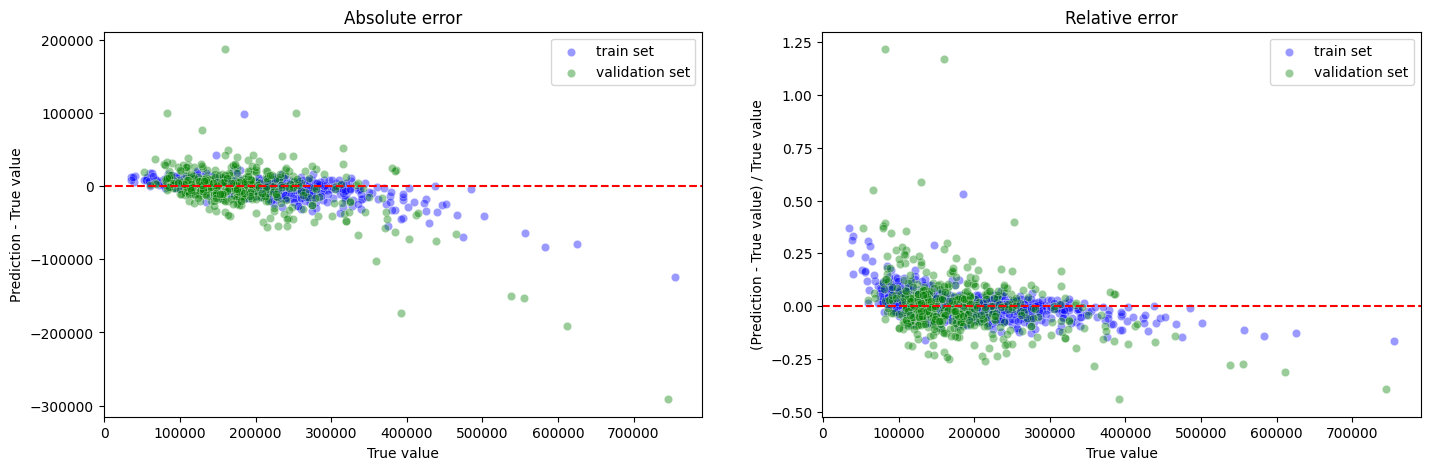

In [28]:
plot_results(
    prediction_train=pred_train_part,
    true_train=y_train_part,
    prediction_validation=pred_vali,
    true_validation=y_vali,
)

## Prediction <a class="anchor"  id="prediction"></a>
We found the best performing model to be `RandomForestRegressor` with the parameters given above. For better predictions, we use this model and train it again on the whole training data set (no validation set split). Then, we create the predictions for the test set and save them in the desired format stated in the [challenge description](https://www.kaggle.com/competitions/home-data-for-ml-course/overview/evaluation).

In [29]:
final_pipeline.fit(X=X_train, y=y_train)
pred_test = final_pipeline.predict(X=X_test)
prediction_df = pd.DataFrame({"Id": X_test.index, "SalePrice": pred_test})
prediction_df.to_csv(predictions_file, index=False)
prediction_df.head()

,Id,SalePrice
0,1461,125322.460829
1,1462,153329.433441
2,1463,179452.766317
3,1464,183565.790495
4,1465,195200.006704


## Conclusion <a class="anchor"  id="conclusion"></a>
For a reasonable deterministic baseline (predicting the mean), we obtain a validation error of approximately $\text{RMSLE}=0.400$. 

For modelling, we use a very basic preprocessing consisting of handling missing data, encoding categorical features and scaling. We also log transform the target to ensure positive predictions. After model selection, we found the best model to be the `RandomForestRegressor` which has a validation error of $\text{RMSLE}=0.142$ (65.5% better than the baseline) with default parameters. This error could be further reduced by 4.2% to $\text{RMSLE}=0.136$ via hyperparameter tuning.

The training error is smaller than the validation error by a factor of roughly $2.7$ which could be a hint of overfitting. But the validation error gets worse when reducing the model's complexity by either reducing the maximal tree depth (`max_depth`) or by increasing the minimum number of observations required to split an internal node in the tree (`min_samples_split`). In the plots of the prediction errors, we find a pattern differing from the zero-line. This indicates that the model is actually slightly underfitting since it does not capture all important information in the data.

For further improvement, especially the preprocessing should be refined so that it is tailored to the specific data. Additional preprocessing steps like removing outliers or engineering new features could be added.